# Cluster PC examples

This notebook supports Chapter 4.3.1 Examples of C-PC in https://sharelatex.tum.de/read/npjkjggtqffh . It shows how to use the clustercausal package to construct a DAG, data and a corresponding C-DAG and then run the PC and C-PC algorithm to compare their outputs. 

In [361]:
#importing libraries and dependencies
%load_ext autoreload
%autoreload 2
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from clustercausal.experiments.Simulator import Simulator
from clustercausal.experiments.Evaluator import Evaluator
from clustercausal.algorithms.ClusterPC import ClusterPC as ClusterPC
from clustercausal.clusterdag.ClusterDAG import ClusterDAG
from clustercausal.utils.Utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example 1: 3-node chain with 2 clusters
This example shows how C-PC can orient additional edges for the graph $X_1 \rightarrow X_2 \rightarrow X_3$, with clusters $C_1 = \{X_1\}$ and $C_2 = \{X_2, X_3\}$.

In [362]:
# Construct DAG as CausalGraph object and get adjacency matrix with make_graph() function from Utils.py
node_names = ['X1', 'X2', 'X3']
parent_dict = {'X1': [], 'X2': ['X1'], 'X3': ['X2']}
cg, W = make_graph(node_names, parent_dict)

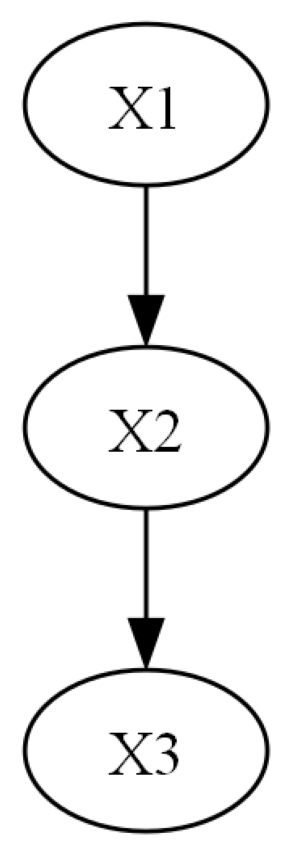

In [363]:
# Draw DAG
cg.draw_pydot_graph()

Next construct ClusterDAG object with C-DAG $C_1 \rightarrow C_2$

In [364]:
cluster_mapping = {'C1': ['X1'], 'C2': ['X2', 'X3']}
cluster_edges = [('C1', 'C2')]
cluster_dag = ClusterDAG(cluster_mapping=cluster_mapping, cluster_edges=cluster_edges)
print(f'Cluster mapping: {cluster_dag.cluster_mapping} \n Cluster edges: {cluster_dag.cluster_edges}')

Cluster mapping: {'C1': ['X1'], 'C2': ['X2', 'X3']} 
 Cluster edges: [('C1', 'C2')]


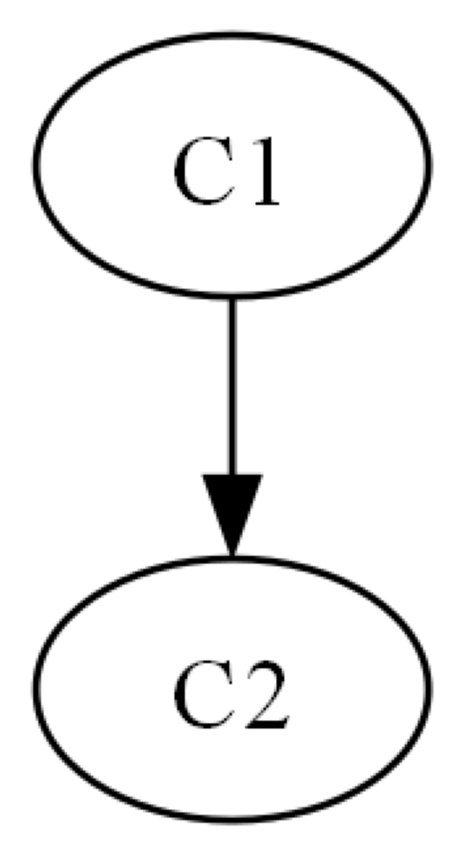

In [365]:
# Draw C-DAG
cluster_dag.cluster_graph.draw_pydot_graph()

Next the causal graph associated to the C-DAG has to be initalized, edges have to be pruned and oriented. cluster_dag.cdag_to_mpdag handles this and then cluster_dag.cg becomes available. This object is the supergraph of all DAGs compatible with the C-DAG

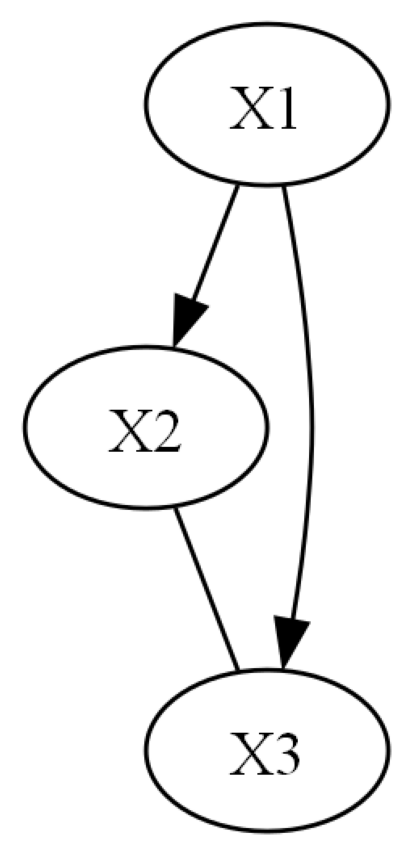

In [366]:
cluster_dag.cdag_to_mpdag()
cluster_dag.cg.draw_pydot_graph()

Lastly, the true dag is added to cluster_dag. 

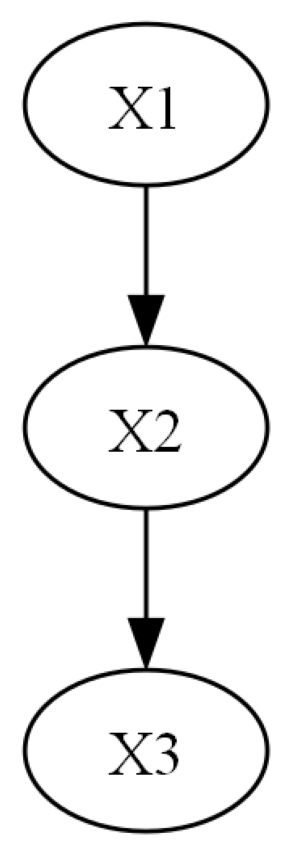

In [367]:
cluster_dag.true_dag = cg
cluster_dag.true_dag.draw_pydot_graph()

Next generate gaussian data for C-PC and PC with Utils.py gaussian_data(). This is an additive noise model with weights 1.0. 

In [368]:
data = gaussian_data(W = W, sample_size = 1000, seed = 42)
data.shape

(1000, 3)

To run PC use the causallearn package. 

In [369]:
pc_est_graph = pc(data, alpha = 0.1, verbose=False, node_names=node_names)

Depth=1, working on node 2: 100%|██████████| 3/3 [00:00<00:00, 185.99it/s]


pc_est_graph is a CausalGraph object and can be drawn

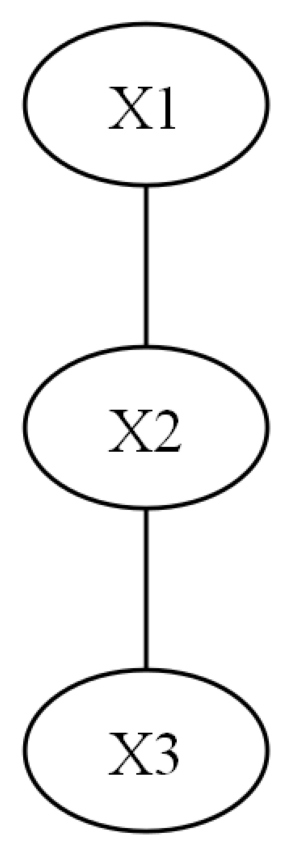

In [370]:
pc_est_graph.draw_pydot_graph()

To run C-PC initialize a cluster_pc object and use the cluster_pc.run() function. 

In [371]:
cluster_pc = ClusterPC(cdag = cluster_dag, data = data, alpha = 0.1, 
                  indep_test = "fisherz", \
                  verbose = False, show_progress=True)
cluster_pc_est_graph = cluster_pc.run()

C2 phase, Depth=1, working on node 2: 100%|██████████| 2/2 [00:00<?, ?it/s, duration: 0.02sec]

Duration of algorithm was 0.02sec


cluster_est_graph is a CausalGraph object and can be drawn. 

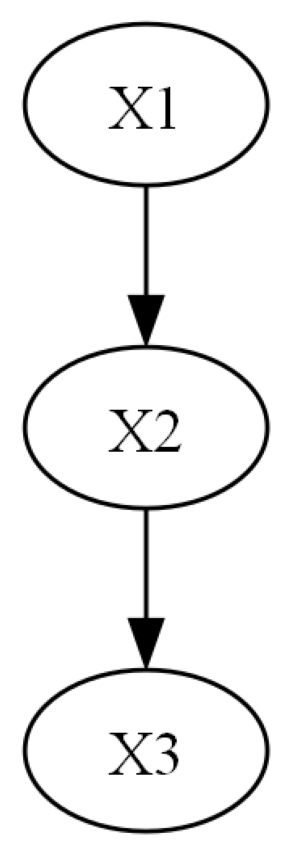

In [372]:
cluster_pc_est_graph.draw_pydot_graph()

Due to the edges from the cluster, C-PC can orient the edge $X_1 \rightarrow X_2$ and then due to orientation rules $X_2 \rightarrow X_3$.

For more evaluations one can call the Evaluator class from clustercausal. The error comes due to precision being nan as there are no true and false positives. SID can be calculated but takes around 5 seconds, can be turned off by changing to get_causallearn_metrics(sid = False). 

The adjacency confusion counts how many edges are correct. Arrow confusion counts how many arrows are correct. SHD is the structural hamming distance and SID is the structural intervention distance.

In [373]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_pc = Evaluator(truth = cluster_dag.true_dag.G, est = pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Adjacency confusion:  {'true_positive': 2, 'false_positive': 0, 'false_negative': 0, 'true_negative': 1, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Arrow confusion:  {'true_positive': 0.0, 'false_positive': 0.0, 'false_negative': 2.0, 'true_negative': 7.0, 'precision': nan, 'recall': 0.0, 'f1_score': nan, 'true_positive_ce': 0.0, 'false_positive_ce': 0.0, 'false_negative_ce': 2.0, 'true_negative_ce': 7.0, 'precision_ce': nan, 'recall_ce': 0.0, 'f1_score_ce': nan}
SHD:  0
SID:  {'sid_lower': 0, 'sid_upper': 6}


In [374]:
eval_cluster_pc = Evaluator(truth = cluster_dag.true_dag.G, est = cluster_pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_cluster_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 2, 'false_positive': 0, 'false_negative': 0, 'true_negative': 1, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Arrow confusion:  {'true_positive': 2.0, 'false_positive': 0.0, 'false_negative': 0.0, 'true_negative': 7.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'true_positive_ce': 2.0, 'false_positive_ce': 0.0, 'false_negative_ce': 0.0, 'true_negative_ce': 7.0, 'precision_ce': 1.0, 'recall_ce': 1.0, 'f1_score_ce': 1.0}
SHD:  0
SID:  {'sid_lower': 0, 'sid_upper': 0}


While both algorithms recover the correct skeleton, C-PC also can recover the correct edge orientations and therefore has better arrow precision and recall as well as lower SID upper bound. 

## Example 2: 5-node graph with 2 clusters
This example shows how C-PC can orient additional edges for a bigger graph with 5 nodes total. 

In [375]:
# Construct DAG as CausalGraph object and get adjacency matrix with make_graph() function from Utils.py
node_names = ['X1', 'X2', 'X3', 'X4', 'X5']
parent_dict = {'X1': [], 'X2': ['X1'], 'X3': ['X2'], 'X4': ['X3'], 'X5': ['X3']}
cg, W = make_graph(node_names, parent_dict)

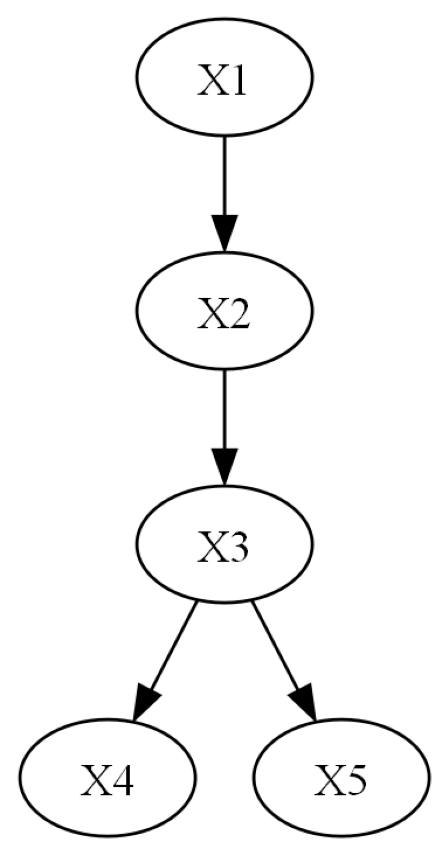

In [376]:
# Draw DAG
cg.draw_pydot_graph()

Next construct ClusterDAG object with C-DAG $C_1 \rightarrow C_2$. It is best practice to have the node_names, the order of the data matrix and the concatenated cluster_mapping lists in the same order. 

I.e. cluster_mapping = {'C2': ['X3', 'X4', 'X5'], 'C1': ['X1', 'X2']} or cluster_mapping = {'C1': ['X1', 'X2'], 'C2': ['X4', 'X5', 'X3']} should be avoided. 

In [377]:
cluster_mapping = {'C1': ['X1', 'X2'], 'C2': ['X3', 'X4', 'X5']}
cluster_edges = [('C1', 'C2')]
cluster_dag = ClusterDAG(cluster_mapping=cluster_mapping, cluster_edges=cluster_edges)
print(f'Cluster mapping: {cluster_dag.cluster_mapping} \n Cluster edges: {cluster_dag.cluster_edges}')

Cluster mapping: {'C1': ['X1', 'X2'], 'C2': ['X3', 'X4', 'X5']} 
 Cluster edges: [('C1', 'C2')]


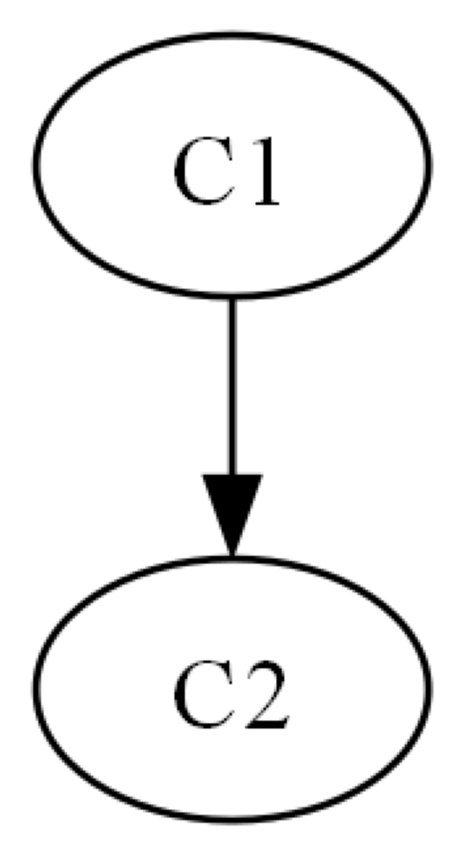

In [378]:
# Draw C-DAG
cluster_dag.cluster_graph.draw_pydot_graph()

Next the causal graph associated to the C-DAG has to be initalized, edges have to be pruned and oriented. cluster_dag.cdag_to_mpdag handles this and then cluster_dag.cg becomes available. This object is the supergraph of all DAGs compatible with the C-DAG. It has directed edges between members of $C_1$ and $C_2$ and undirected edges within clusters. 

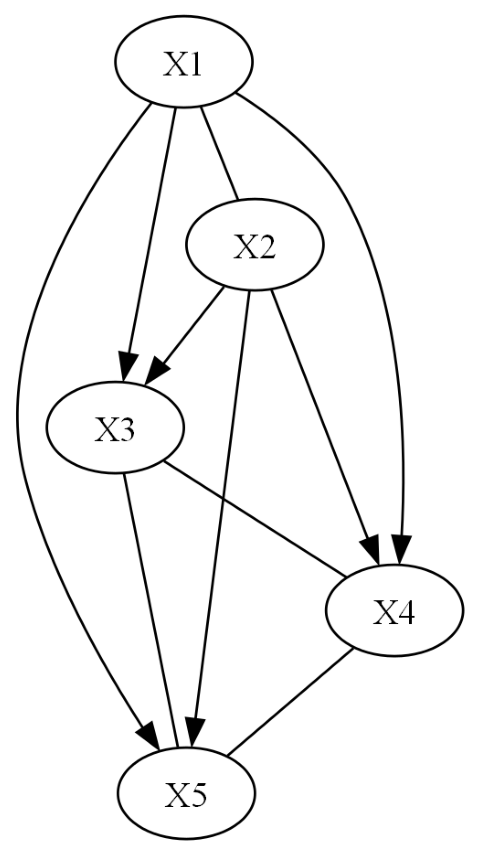

In [379]:
cluster_dag.cdag_to_mpdag()
cluster_dag.cg.draw_pydot_graph()

Lastly, the true dag is added to cluster_dag. 

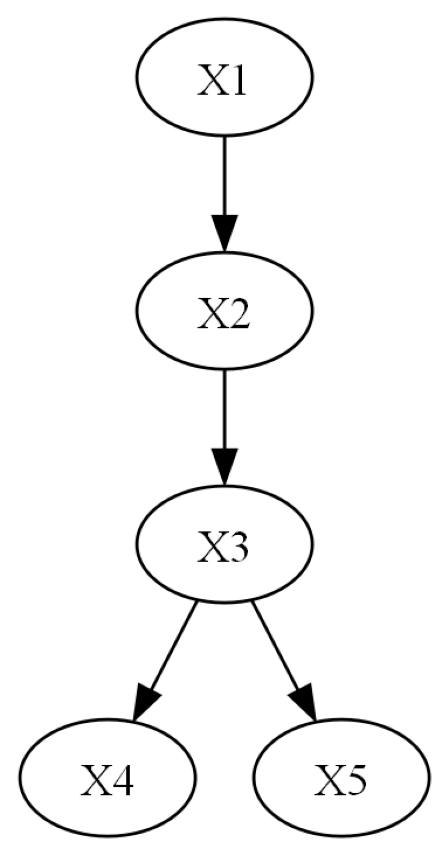

In [380]:
cluster_dag.true_dag = cg
cluster_dag.true_dag.draw_pydot_graph()

Next generate gaussian data for C-PC and PC with Utils.py gaussian_data(). This is an additive noise model with weights 1.0. 

In [381]:
data = gaussian_data(W = W, sample_size = 1000, seed = 42)
data.shape

(1000, 5)

To run PC use the causallearn package. 

In [382]:
pc_est_graph = pc(data, alpha = 0.1, verbose=False, node_names=node_names)

Depth=2, working on node 4: 100%|██████████| 5/5 [00:00<00:00, 305.97it/s]


pc_est_graph is a CausalGraph object and can be drawn

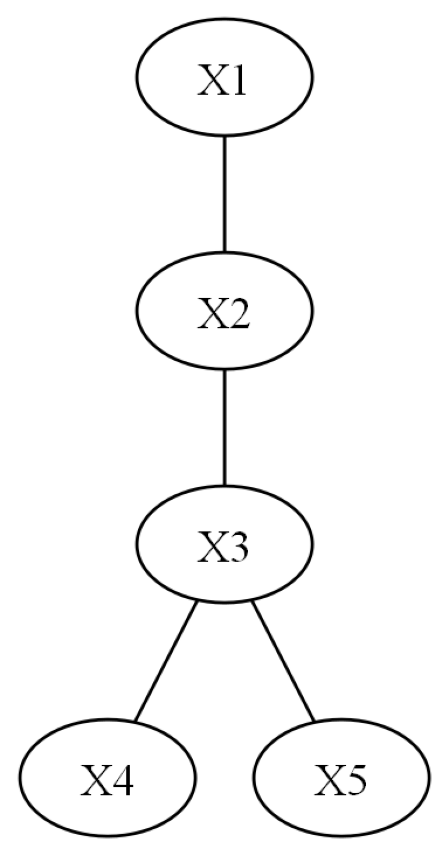

In [383]:
pc_est_graph.draw_pydot_graph()

To run C-PC initialize a cluster_pc object and use the cluster_pc.run() function. 

In [384]:
cluster_pc = ClusterPC(cdag = cluster_dag, data = data, alpha = 0.1, 
                  indep_test = "fisherz", \
                  verbose = False, show_progress=True)
cluster_pc_est_graph = cluster_pc.run()

C2 phase, Depth=2, working on node 4: 100%|██████████| 3/3 [00:00<00:00, 194.66it/s, duration: 0.05sec]

Duration of algorithm was 0.05sec


cluster_est_graph is a CausalGraph object and can be drawn. 

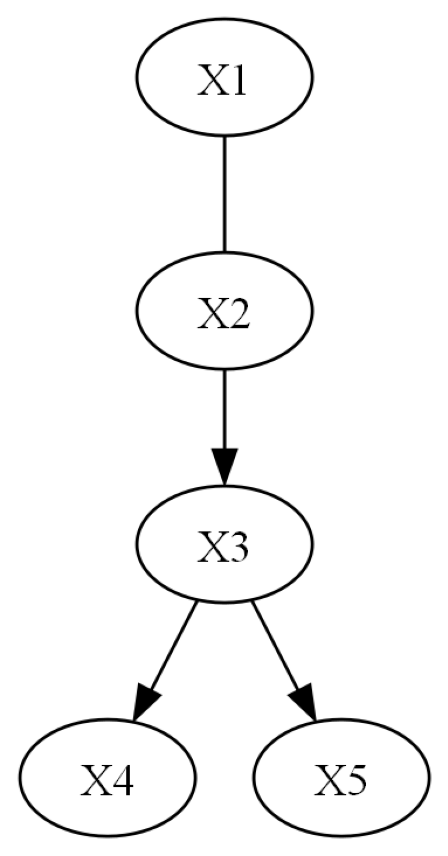

In [385]:
cluster_pc_est_graph.draw_pydot_graph()

Due to the edges from the cluster, C-PC can orient almost all edges. This is a big improvement compared to PC as it allows much better causal effect estimation. This is also reflected in the upper SID bound being 5 for C-PC instead of 15 for PC. 

For more evaluations one can call the Evaluator class from clustercausal. The error comes due to precision being nan as there are no true and false positives. SID can be calculated but takes around 5 seconds, can be turned off by changing to get_causallearn_metrics(sid = False). 

The adjacency confusion counts how many edges are correct. Arrow confusion counts how many arrows are correct. SHD is the structural hamming distance and SID is the structural intervention distance.

In [386]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_pc = Evaluator(truth = cluster_dag.true_dag.G, est = pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Adjacency confusion:  {'true_positive': 4, 'false_positive': 0, 'false_negative': 0, 'true_negative': 6, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Arrow confusion:  {'true_positive': 0.0, 'false_positive': 0.0, 'false_negative': 4.0, 'true_negative': 21.0, 'precision': nan, 'recall': 0.0, 'f1_score': nan, 'true_positive_ce': 0.0, 'false_positive_ce': 0.0, 'false_negative_ce': 4.0, 'true_negative_ce': 21.0, 'precision_ce': nan, 'recall_ce': 0.0, 'f1_score_ce': nan}
SHD:  0
SID:  {'sid_lower': 0, 'sid_upper': 15}


In [387]:
eval_cluster_pc = Evaluator(truth = cluster_dag.true_dag.G, est = cluster_pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_cluster_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 4, 'false_positive': 0, 'false_negative': 0, 'true_negative': 6, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Arrow confusion:  {'true_positive': 3.0, 'false_positive': 0.0, 'false_negative': 1.0, 'true_negative': 21.0, 'precision': 1.0, 'recall': 0.75, 'f1_score': 0.8571428571428571, 'true_positive_ce': 3.0, 'false_positive_ce': 0.0, 'false_negative_ce': 1.0, 'true_negative_ce': 21.0, 'precision_ce': 1.0, 'recall_ce': 0.75, 'f1_score_ce': 0.8571428571428571}
SHD:  0
SID:  {'sid_lower': 0, 'sid_upper': 5}


Again both algorithms recover the correct skeleton, C-PC also can recover the correct edge orientations and therefore has better arrow precision and recall as well as lower SID upper bound. 

## Example 3: 7-node graph with 3 clusters
This example shows how C-PC can orient additional edges for a more complicated graph with 7 nodes total and 3 clusters. 

In [480]:
# Construct DAG as CausalGraph object and get adjacency matrix with make_graph() function from Utils.py
node_names = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']
parent_dict = {'X1': [], 'X2': ['X1'], 'X3': [], 'X4': ['X3'], 'X5': ['X3'], 'X6' : ['X1', 'X4'], 'X7': ['X3', 'X6']}
cg, W = make_graph(node_names, parent_dict)

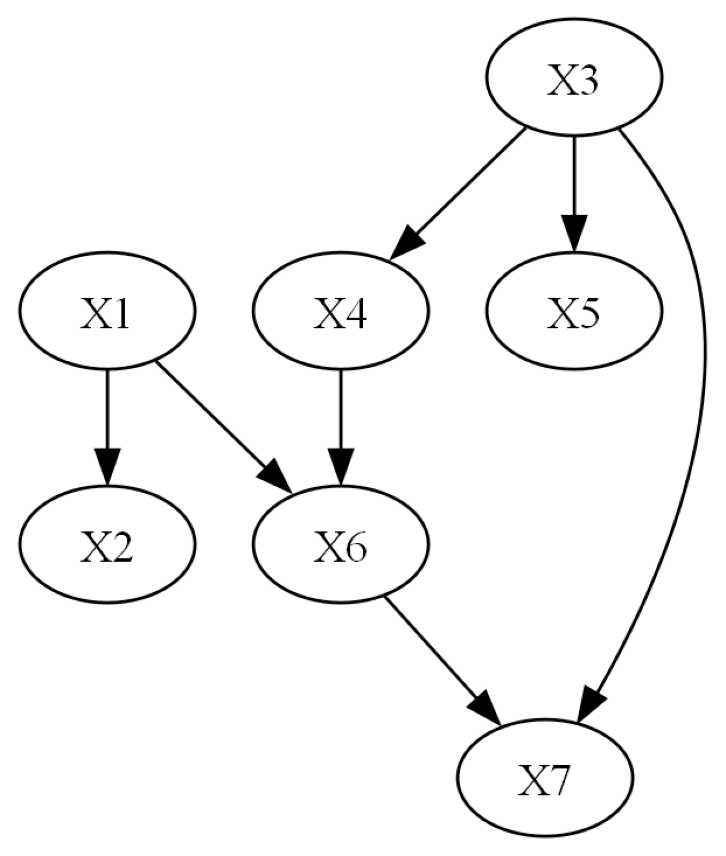

In [481]:
# Draw DAG
cg.draw_pydot_graph()

Next construct ClusterDAG object with C-DAG $C_1 \rightarrow C_3, C_2 \rightarrow C_3$. 

In [482]:
cluster_mapping = {'C1': ['X1', 'X2'], 'C2': ['X3', 'X4'] ,'C3': ['X5', 'X6', 'X7']}
cluster_edges = [('C1', 'C3'), ('C2', 'C3')]
cluster_dag = ClusterDAG(cluster_mapping=cluster_mapping, cluster_edges=cluster_edges)
print(f'Cluster mapping: {cluster_dag.cluster_mapping} \n Cluster edges: {cluster_dag.cluster_edges}')

Cluster mapping: {'C1': ['X1', 'X2'], 'C2': ['X3', 'X4'], 'C3': ['X5', 'X6', 'X7']} 
 Cluster edges: [('C1', 'C3'), ('C2', 'C3')]


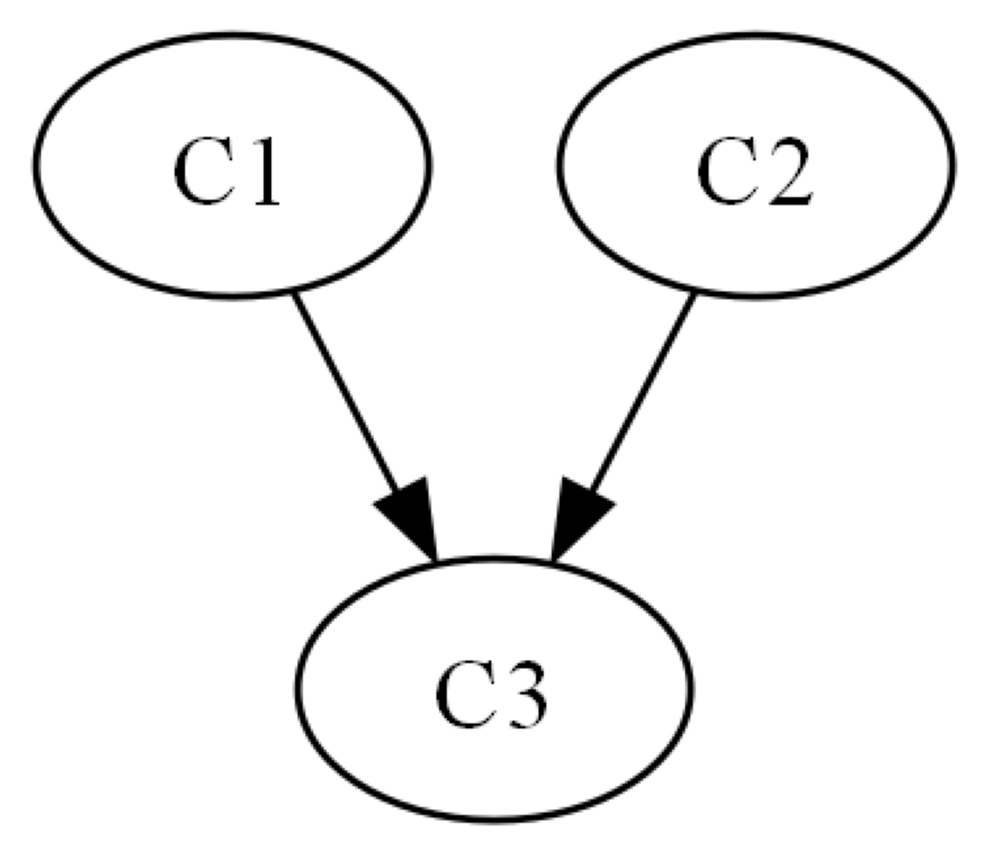

In [483]:
# Draw C-DAG
cluster_dag.cluster_graph.draw_pydot_graph()

Next the causal graph associated to the C-DAG has to be initalized, edges have to be pruned and oriented. cluster_dag.cdag_to_mpdag handles this and then cluster_dag.cg becomes available. This object is the supergraph of all DAGs compatible with the C-DAG. It has directed edges between members of $C_1$ and $C_2$ and undirected edges within clusters. 

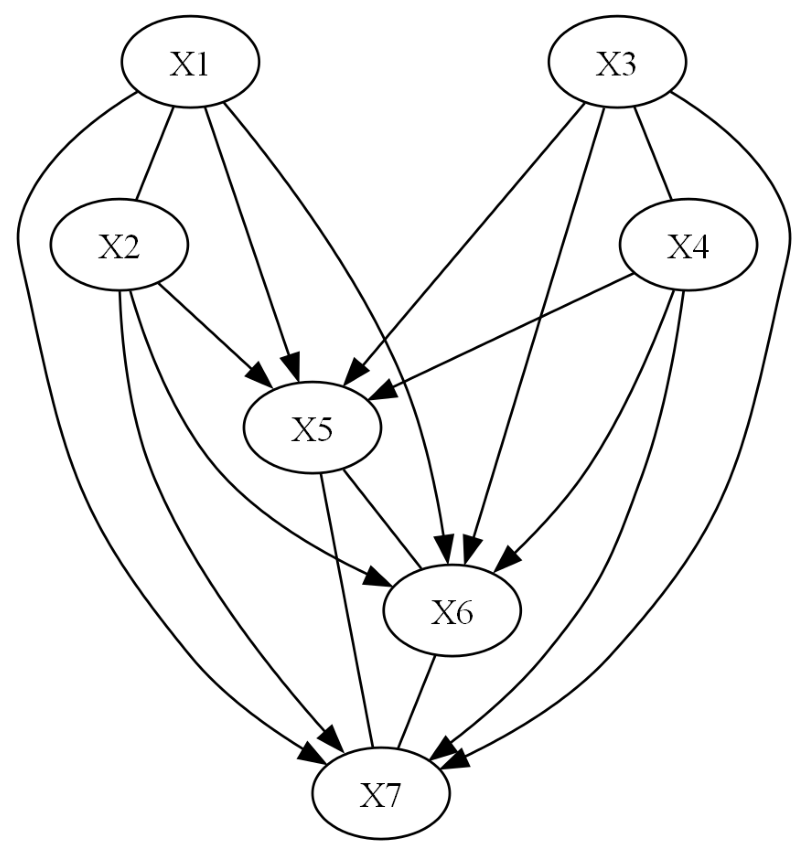

In [484]:
cluster_dag.cdag_to_mpdag()
cluster_dag.cg.draw_pydot_graph()

Lastly, the true dag is added to cluster_dag. 

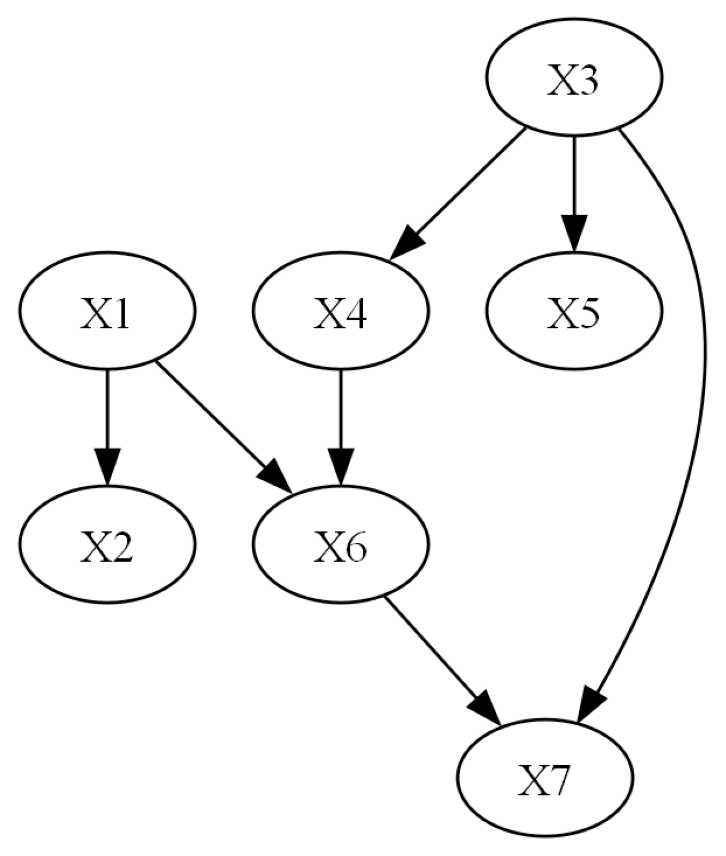

In [485]:
cluster_dag.true_dag = cg
cluster_dag.true_dag.draw_pydot_graph()

Next generate gaussian data for C-PC and PC with Utils.py gaussian_data(). This is an additive noise model with weights 1.0. 

In [486]:
data = gaussian_data(W = W, sample_size = 1000, seed = 42)
data.shape

(1000, 7)

To run PC use the causallearn package. 

In [487]:
pc_est_graph = pc(data, alpha = 0.1, verbose=False, node_names=node_names)

Depth=2, working on node 6: 100%|██████████| 7/7 [00:00<00:00, 380.73it/s] 


pc_est_graph is a CausalGraph object and can be drawn

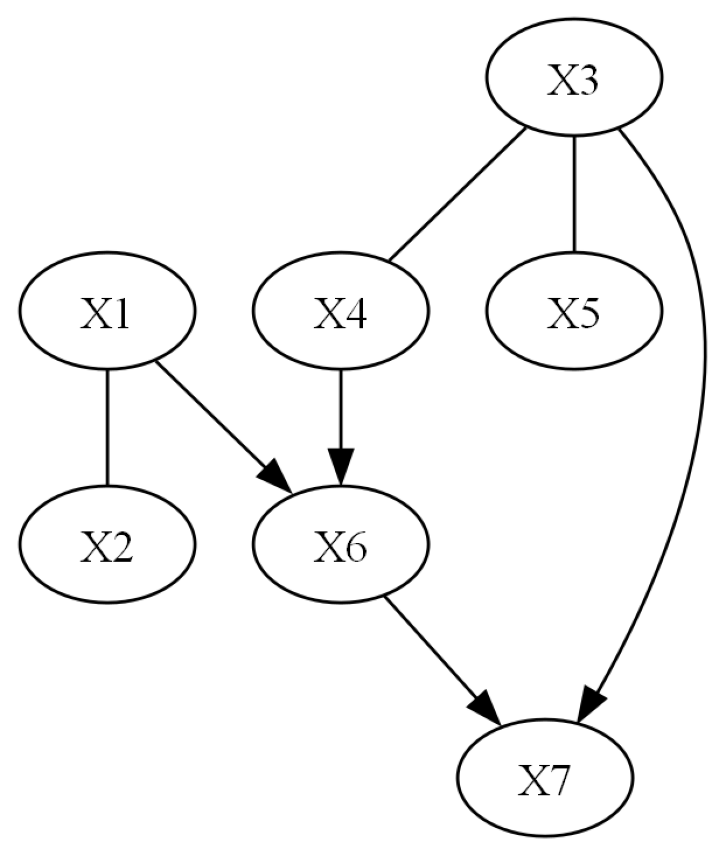

In [488]:
pc_est_graph.draw_pydot_graph()

To run C-PC initialize a cluster_pc object and use the cluster_pc.run() function. 

In [489]:
cluster_pc = ClusterPC(cdag = cluster_dag, data = data, alpha = 0.1, 
                  indep_test = "fisherz", \
                  verbose = False, show_progress=True)
cluster_pc_est_graph = cluster_pc.run()

C3 phase, Depth=2, working on node 6: 100%|██████████| 3/3 [00:00<?, ?it/s, duration: 0.05sec]

Duration of algorithm was 0.10sec


cluster_est_graph is a CausalGraph object and can be drawn. 

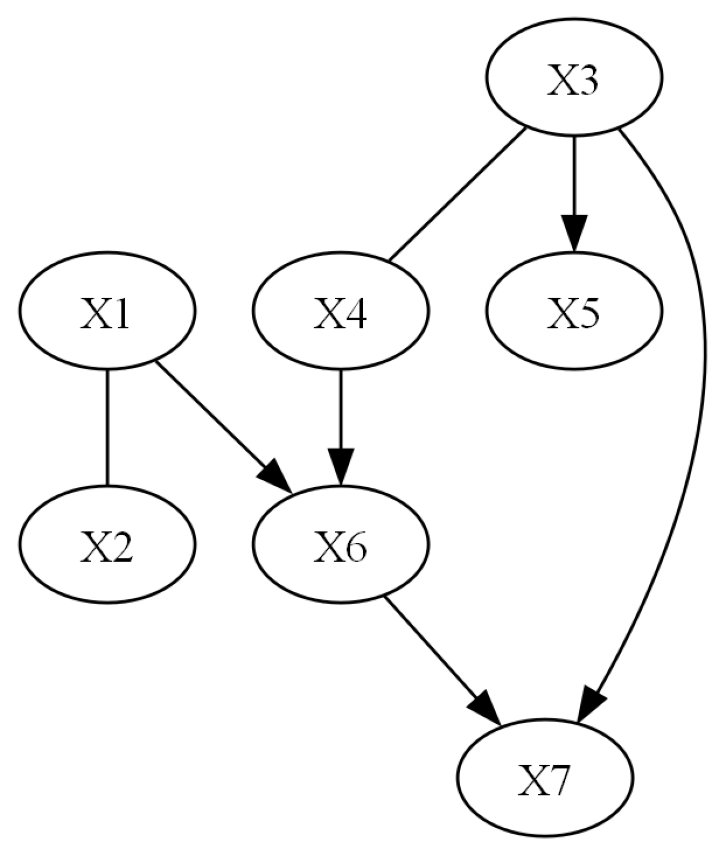

In [490]:
cluster_pc_est_graph.draw_pydot_graph()

Due to the two colliders, the performance here is very similar, C-PC can only orient the additional edge $X_3 \rightarrow X_5$. 

For more evaluations one can call the Evaluator class from clustercausal. The error comes due to precision being nan as there are no true and false positives. SID can be calculated but takes around 5 seconds, can be turned off by changing to get_causallearn_metrics(sid = False). 

The adjacency confusion counts how many edges are correct. Arrow confusion counts how many arrows are correct. SHD is the structural hamming distance and SID is the structural intervention distance.

In [491]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_pc = Evaluator(truth = cluster_dag.true_dag.G, est = pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 7, 'false_positive': 0, 'false_negative': 0, 'true_negative': 14, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Arrow confusion:  {'true_positive': 4.0, 'false_positive': 0.0, 'false_negative': 3.0, 'true_negative': 42.0, 'precision': 1.0, 'recall': 0.5714285714285714, 'f1_score': 0.7272727272727273, 'true_positive_ce': 4.0, 'false_positive_ce': 0.0, 'false_negative_ce': 3.0, 'true_negative_ce': 42.0, 'precision_ce': 1.0, 'recall_ce': 0.5714285714285714, 'f1_score_ce': 0.7272727272727273}
SHD:  0
SID:  {'sid_lower': 0, 'sid_upper': 10}


In [492]:
eval_cluster_pc = Evaluator(truth = cluster_dag.true_dag.G, est = cluster_pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_cluster_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 7, 'false_positive': 0, 'false_negative': 0, 'true_negative': 14, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Arrow confusion:  {'true_positive': 5.0, 'false_positive': 0.0, 'false_negative': 2.0, 'true_negative': 42.0, 'precision': 1.0, 'recall': 0.7142857142857143, 'f1_score': 0.8333333333333333, 'true_positive_ce': 5.0, 'false_positive_ce': 0.0, 'false_negative_ce': 2.0, 'true_negative_ce': 42.0, 'precision_ce': 1.0, 'recall_ce': 0.7142857142857143, 'f1_score_ce': 0.8333333333333333}
SHD:  0
SID:  {'sid_lower': 0, 'sid_upper': 10}


Again both algorithms recover the correct skeleton, C-PC also can recover the correct edge orientations and therefore has better arrow precision and recall as well as lower SID upper bound. 

One can also compare the numer of CI tests the two methods perform comparing the 2 cluster C-PC with a 1 cluster C-PC, which is equivalent to PC. 

In [496]:
no_clust_cluster_mapping = {'C1': ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']}
no_clust_cluster_edges = []
no_clust_cluster_dag = ClusterDAG(cluster_mapping=no_clust_cluster_mapping, cluster_edges=no_clust_cluster_edges)

In [497]:
no_clust_cpc = ClusterPC(cdag = no_clust_cluster_dag, data = data, alpha = 0.1, \
                    indep_test = "fisherz", verbose = False, show_progress=True, cluster_only=True)
no_clust_cpc_est_graph = no_clust_cpc.run()

C1 phase, Depth=2, working on node 6: 100%|██████████| 7/7 [00:00<00:00, 407.04it/s, duration: 0.10sec]

Duration of algorithm was 0.12sec


In [500]:
print(f' Without clustering: {no_clust_cpc.no_of_indep_tests_performed} CI tests, \n with 2 clusters: {cluster_pc.no_of_indep_tests_performed} CI tests')

 Without clustering: 174 CI tests, 
 with 2 clusters: 109 CI tests


The number of CI tests when going to C-PC was reduced by around 37%. 

## Example 4: 10-node graph with 1 cluster
This example shows how C-PC retrieves the same result as PC when every node is in the same cluster.

In [ ]:
# Construct DAG as CausalGraph object and get adjacency matrix with make_graph() function from Utils.py
node_names = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']
parent_dict = {'X1': [], 'X2': ['X1'], 'X3': ['X1'], 'X4': ['X3', 'X2'], 'X5': ['X3'], 'X6' : ['X1', 'X4', 'X5'], 'X7': ['X3', 'X6'], 'X8': ['X7'], 'X9': ['X7'], 'X10': ['X7']}
cg, W = make_graph(node_names, parent_dict)

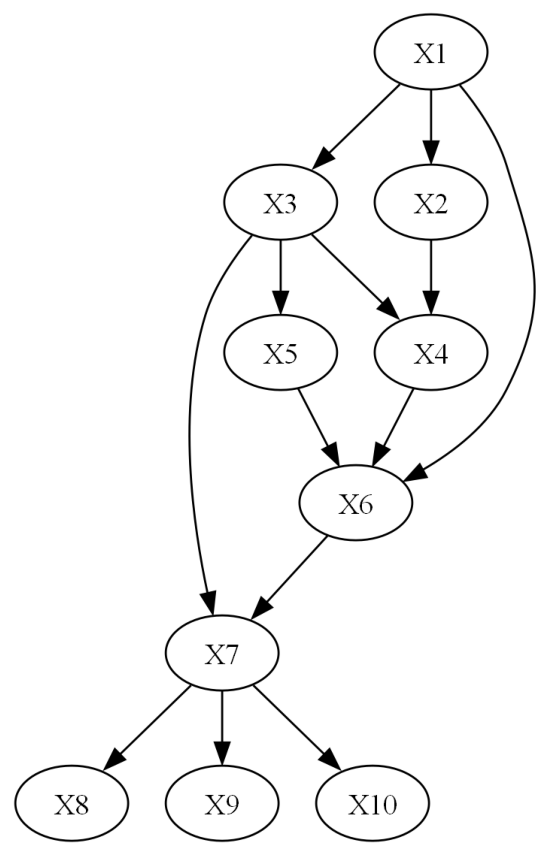

In [ ]:
# Draw DAG
cg.draw_pydot_graph()

Next construct ClusterDAG object with C-DAG. 

In [ ]:
cluster_mapping = {'C1': ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']}
cluster_edges = []
cluster_dag = ClusterDAG(cluster_mapping=cluster_mapping, cluster_edges=cluster_edges)
print(f'Cluster mapping: {cluster_dag.cluster_mapping} \n Cluster edges: {cluster_dag.cluster_edges}')

Cluster mapping: {'C1': ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']} 
 Cluster edges: []


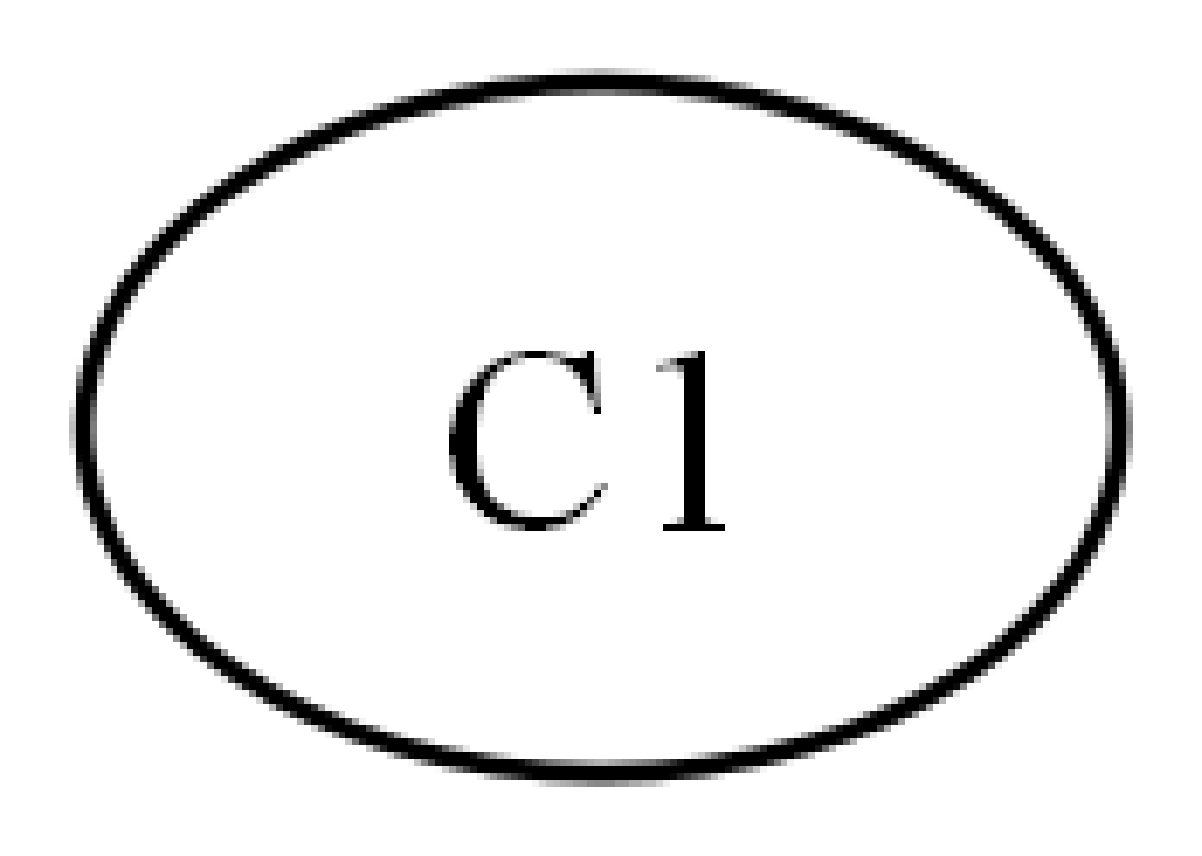

In [ ]:
# Draw C-DAG
cluster_dag.cluster_graph.draw_pydot_graph()

Next the causal graph associated to the C-DAG has to be initalized, edges have to be pruned and oriented. cluster_dag.cdag_to_mpdag handles this and then cluster_dag.cg becomes available. This object is the supergraph of all DAGs compatible with the C-DAG. It has directed edges between members of $C_1$ and $C_2$ and undirected edges within clusters. 

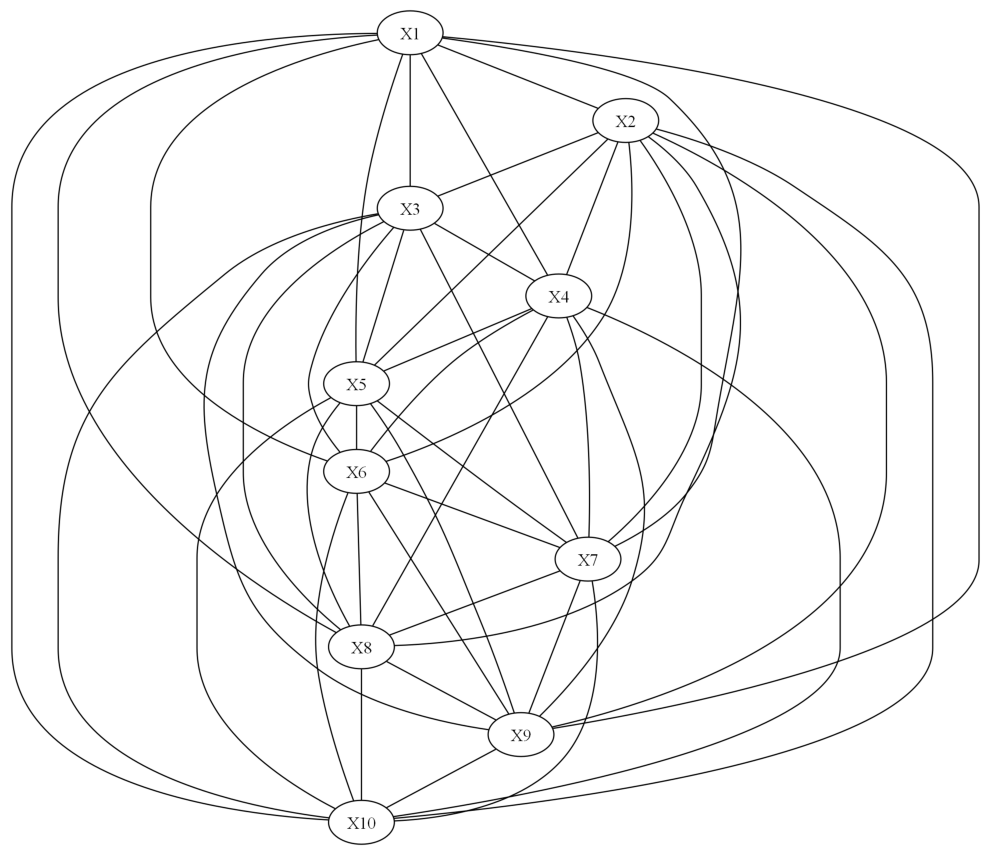

In [ ]:
cluster_dag.cdag_to_mpdag()
cluster_dag.cg.draw_pydot_graph()

Lastly, the true dag is added to cluster_dag. 

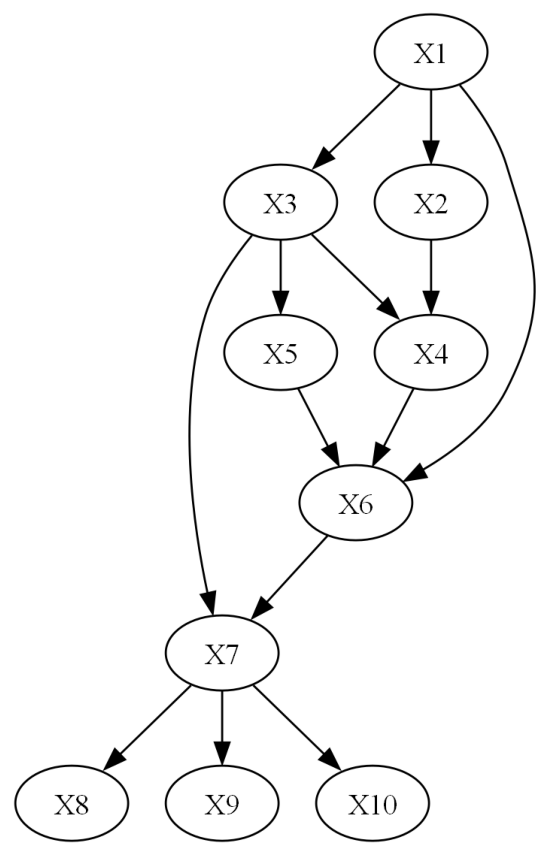

In [ ]:
cluster_dag.true_dag = cg
cluster_dag.true_dag.draw_pydot_graph()

Next generate gaussian data for C-PC and PC with Utils.py gaussian_data(). This is an additive noise model with weights 1.0. 

In [ ]:
data = gaussian_data(W = W, sample_size = 1000, seed = 42)
data.shape

(1000, 10)

To run PC use the causallearn package. 

In [ ]:
pc_est_graph = pc(data, alpha = 0.1, verbose=False, node_names=node_names)

Depth=4, working on node 9: 100%|██████████| 10/10 [00:00<00:00, 451.10it/s]


pc_est_graph is a CausalGraph object and can be drawn

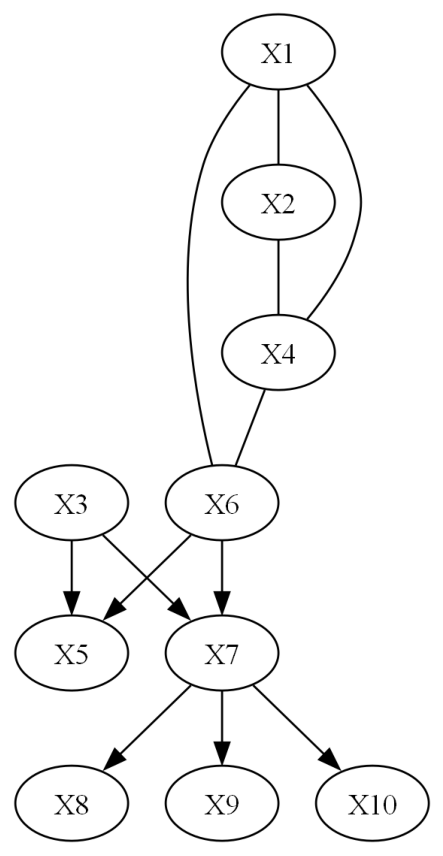

In [ ]:
pc_est_graph.draw_pydot_graph()

To run C-PC initialize a cluster_pc object and use the cluster_pc.run() function. 

In [ ]:
cluster_pc = ClusterPC(cdag = cluster_dag, data = data, alpha = 0.1, 
                  indep_test = "fisherz", \
                  verbose = False, show_progress=True)
cluster_pc_est_graph = cluster_pc.run()

C1 phase, Depth=4, working on node 9: 100%|██████████| 10/10 [00:00<00:00, 640.00it/s, duration: 0.38sec]


Duration of algorithm was 0.39sec


cluster_est_graph is a CausalGraph object and can be drawn. 

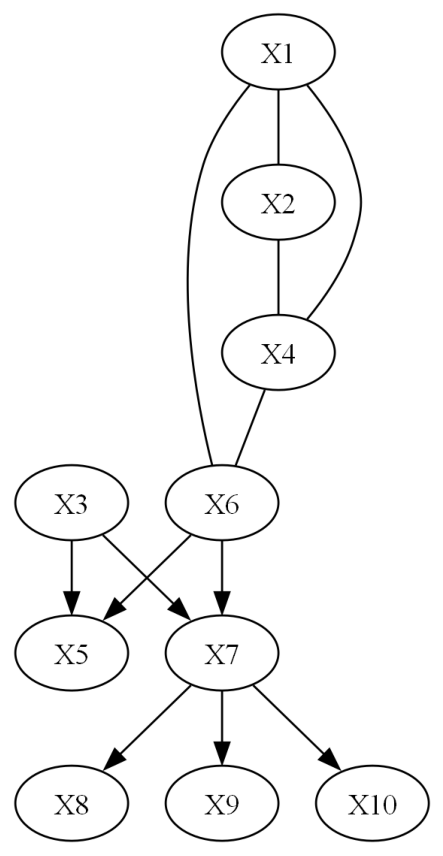

In [ ]:
cluster_pc_est_graph.draw_pydot_graph()

For more evaluations one can call the Evaluator class from clustercausal. The error comes due to precision being nan as there are no true and false positives. SID can be calculated but takes around 5 seconds, can be turned off by changing to get_causallearn_metrics(sid = False). 

The adjacency confusion counts how many edges are correct. Arrow confusion counts how many arrows are correct. SHD is the structural hamming distance and SID is the structural intervention distance.

In [ ]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_pc = Evaluator(truth = cluster_dag.true_dag.G, est = pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 11, 'false_positive': 1, 'false_negative': 2, 'true_negative': 31, 'precision': 0.9166666666666666, 'recall': 0.8461538461538461, 'f1_score': 0.8799999999999999}
Arrow confusion:  {'true_positive': 6.0, 'false_positive': 1.0, 'false_negative': 7.0, 'true_negative': 86.0, 'precision': 0.8571428571428571, 'recall': 0.46153846153846156, 'f1_score': 0.6, 'true_positive_ce': 6.0, 'false_positive_ce': 1.0, 'false_negative_ce': 5.0, 'true_negative_ce': 88.0, 'precision_ce': 0.8571428571428571, 'recall_ce': 0.5454545454545454, 'f1_score_ce': 0.6666666666666665}
SHD:  4
SID:  {'sid_lower': 30, 'sid_upper': 51}


In [ ]:
eval_cluster_pc = Evaluator(truth = cluster_dag.true_dag.G, est = cluster_pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_cluster_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 11, 'false_positive': 1, 'false_negative': 2, 'true_negative': 31, 'precision': 0.9166666666666666, 'recall': 0.8461538461538461, 'f1_score': 0.8799999999999999}
Arrow confusion:  {'true_positive': 6.0, 'false_positive': 1.0, 'false_negative': 7.0, 'true_negative': 86.0, 'precision': 0.8571428571428571, 'recall': 0.46153846153846156, 'f1_score': 0.6, 'true_positive_ce': 6.0, 'false_positive_ce': 1.0, 'false_negative_ce': 5.0, 'true_negative_ce': 88.0, 'precision_ce': 0.8571428571428571, 'recall_ce': 0.5454545454545454, 'f1_score_ce': 0.6666666666666665}
SHD:  4
SID:  {'sid_lower': 30, 'sid_upper': 51}


As can be seen, PC and C-PC retrieve the exact same graph. 